IMPORTANT EDIT: A basic assumption in this notebook is wrong: the signal data is *not* the result of a first-order Markov process. In fact, the open\_channel data itself is the result of a first-order Markov process. Therefore, the situation is more complicated than described here. Still, most of the arguments remain relevant. I've explained more [here](https://www.kaggle.com/c/liverpool-ion-switching/discussion/140634).

This notebook analyzes and visualizes the training data and demonstrates that the signal data is indeed the result of a simple Markov process (however, a hidden one) combined with Gaussian (white) noise. **This puts a strong upper limit on what a model can achieve in this competition.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

filepath = './drive/My Drive/Colab Notebooks/liverpool-ion-switching/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Let's load the data and split it into the 10 separate measurement sequences:

In [0]:
df_train = pd.read_csv(filepath + 'train.csv')

train_time   = df_train["time"].values.reshape(-1,500000)
train_signal = df_train["signal"].values.reshape(-1,500000)
train_opench = df_train["open_channels"].values.reshape(-1,500000)

In [0]:
def create_axes_grid(numplots_x, numplots_y, plotsize_x=6, plotsize_y=3):
    fig, axes = plt.subplots(numplots_y, numplots_x)
    fig.set_size_inches(plotsize_x * numplots_x, plotsize_y * numplots_y)
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    return fig, axes
    
def set_axes(axes, use_grid=True, x_val = [0,100,10,5], y_val = [-50,50,10,5]):
    axes.grid(use_grid)
    axes.tick_params(which='both', direction='inout', top=True, right=True, labelbottom=True, labelleft=True)
    axes.set_xlim(x_val[0], x_val[1])
    axes.set_ylim(y_val[0], y_val[1])
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[2] + 1).astype(int)))
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[3] + 1).astype(int)), minor=True)
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[2] + 1).astype(int)))
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[3] + 1).astype(int)), minor=True)

Here is the full training data (signal and ground truth (open channels)), each sequence has 500.000 samples corresponding to 50s of data acquisition. 5 different "data models" can be visually identified (sequences 0, 2, 3, 4, 5), shown here in red. We will use these sequences in the following, as the others are from the same models, just shifted by a slow drift.

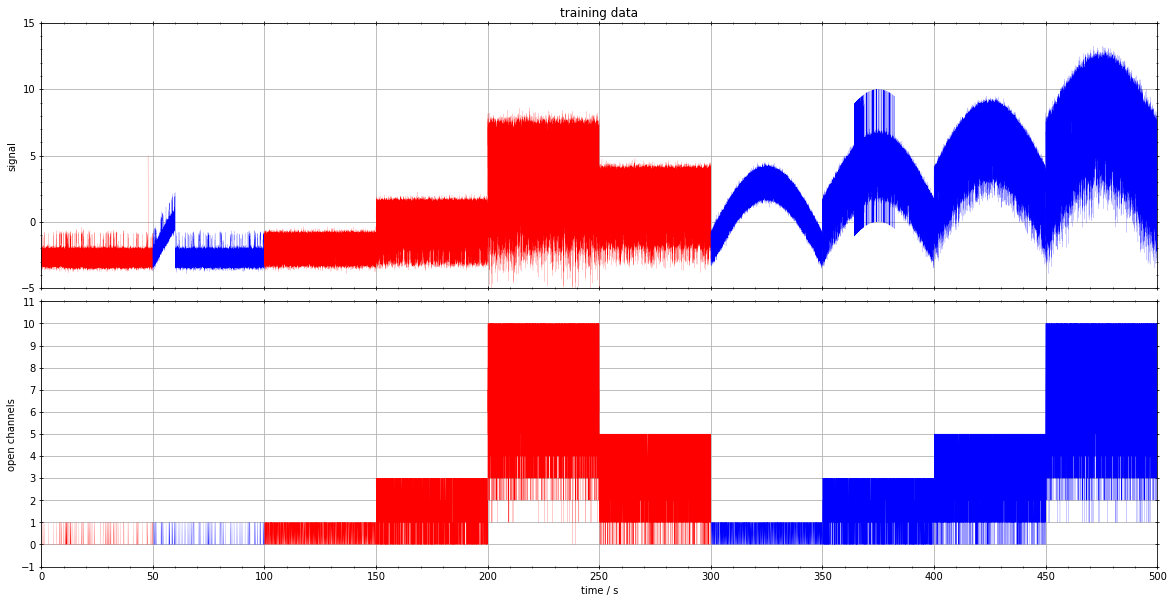

In [6]:
fig, axes = create_axes_grid(1,2,20,5)
set_axes(axes[0], x_val=[0,500,50,10], y_val=[-5,15,5,1])
set_axes(axes[1], x_val=[0,500,50,10], y_val=[-1,11,1,1])

axes[0].set_title('training data')
axes[0].set_xticklabels('')
axes[1].set_xlabel('time / s')
axes[0].set_ylabel('signal')
axes[1].set_ylabel('open channels')

for i in range(10):
    if i in [0,2,3,4,5]:
        col = 'red'
    else:
        col = 'blue'
    axes[0].plot(train_time[i], train_signal[i], color=col, linewidth=0.1);
    axes[1].plot(train_time[i], train_opench[i], color=col, linewidth=0.1);

As has been mentioned at several points in this competition (e.g. in the original paper and in the discussions), the underlying ground truth data is the result of a Markov process. This means that the probability for the value of data point n+1 depends *only* on data point n. A Markov process can be fully specified by the transition matrix P: the value of the current sample n corresponds to the rows of P and the value of the next sample n+1 corresponds to the columns of P. P can be calculated for any of the training sequences from the open_channel data:

In [0]:
def markov_p(data):
    channel_range = np.unique(data)
    channel_bins = np.append(channel_range, 11)
    data_next = np.roll(data, -1)
    matrix = []
    for i in channel_range:
        current_row = np.histogram(data_next[data == i], bins=channel_bins)[0]
        current_row = current_row / np.sum(current_row)
        matrix.append(current_row)
    return np.array(matrix)

Let's take a look at the transition matrix for sequence 3, which contains 0-3 open channels:

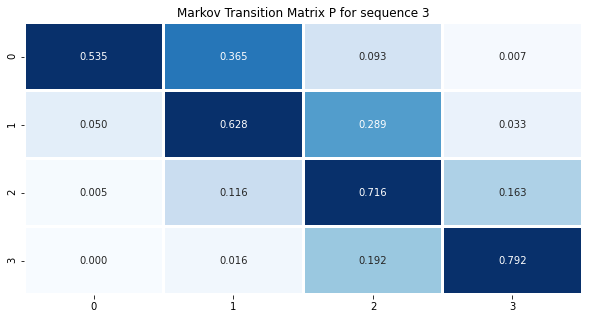

In [8]:
p03 = markov_p(train_opench[3])

fig, axes = create_axes_grid(1,1,10,5)
axes.set_title('Markov Transition Matrix P for sequence 3')
sns.heatmap(
    p03,
    annot=True, fmt='.3f', cmap='Blues', cbar=False,
    ax=axes, vmin=0, vmax=0.5, linewidths=2);

*All* possible information on the underlying process is contained in this matrix. A nice way of checking this is by using the fact that the probability distribution for the open_channel data can be calculated as the eigenvector of transpose(P) to the eigenvalue 1 (this is true for any stationary Markov process). Let's check this:

In [9]:
eig_values, eig_vectors = np.linalg.eig(np.transpose(p03))
print("Eigenvalues :", eig_values)

Eigenvalues : [1.         0.73540873 0.39680602 0.53951065]


Indeed, the first eigenvalue is +1 (this has to be true for any correct P). Let's get the corresponding eigenvector, normalized to sum(elements) = 1:

In [10]:
dist03 = eig_vectors[:,0] / np.sum(eig_vectors[:,0])
print("Probability distribution for sequence 3 :", dist03)

Probability distribution for sequence 3 : [0.023556 0.17386  0.433766 0.368818]


If it's indeed a Markov process, this should be identical to the actual probability distribution of open_channel states. Check:

In [11]:
np.histogram(train_opench[3], bins=[0,1,2,3,4], density=True)[0]

array([0.023556, 0.17386 , 0.433766, 0.368818])

Q.E.D.

Now to the most interesting part: the signal data. We can easily visualize this data in a transition matrix format. Note that the y axis is flipped compared with the rows of the matrix P (row indices increase downward, a y-axis increases upward):

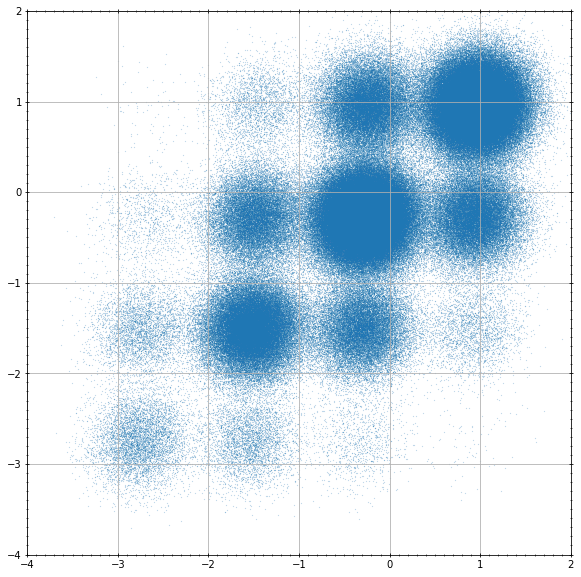

In [12]:
data = train_signal[3]

fig, axes = create_axes_grid(1,1,10,10)
set_axes(axes, x_val=[-4,2,1,.1], y_val=[-4,2,1,.1])

axes.set_aspect('equal')
axes.scatter(np.roll(data,-1), data, s=.01);

This is all information contained in the signal. There are no hidden features, all that remains to be done is to separate the spherical point clouds. If the noise were smaller, this would be trivial. The only problem in this competition is due to the fact that the noise smears the different "matrix elements" into each other. Ans since it's white (Gaussian) noise (I have checked this via Fourier transformation), it is impossible to do this better than a certain upper limit. This is especially true for the most "smeared" sequence 4. Here it is with the color indicating the "true y-value":

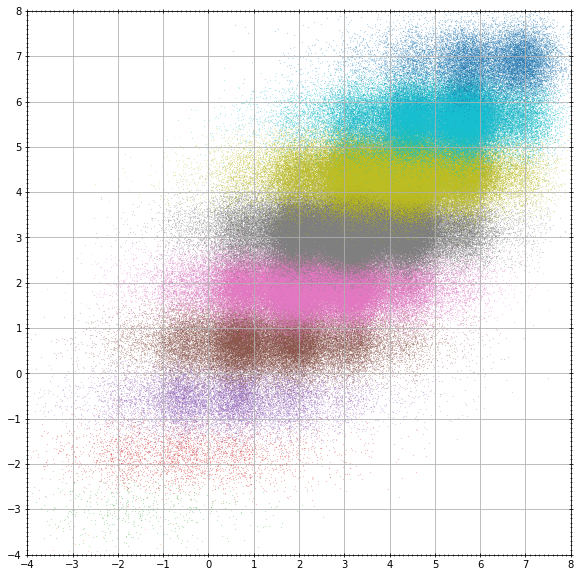

In [13]:
data = train_signal[4]
data_true = train_opench[4]

fig, axes = create_axes_grid(1,1,10,10)
set_axes(axes, x_val=[-4,8,1,.1], y_val=[-4,8,1,.1])

axes.set_aspect('equal')
for i in range(11):
    axes.scatter(np.roll(data,-1)[data_true==i], data[data_true==i], s=.01);

There is absolutely no way to separate the different colors by using any clever engineered "special feature" in a ML model. Otherwise it wouldn't be a Markov process.
This is the reason why even a trivial model achieves 0.93 on the LB and the best models achieve 0.941. It's very likely that

a) there won't be any more increases of more than maybe 0.002 on the LB

b) already 0.94 is due to the specific train and test data and unlikely to generalize to new unseen data.

Everyone can in principle check this: it's easy to generate new training data. Just use P to generate new open_channel data and then add gaussian noise with mean and std taken from the individual "blobs" in the training data (I've checked: all open_channel values have the same noise standard deviation and also identical distance).

Have fun!